$$
\newcommand{\Ex}{\mathbb{E}}
\newcommand{\Var}{\mathrm{Var}}
\newcommand{\Cov}{\mathrm{Cov}}
\newcommand{\SampleAvg}{\frac{1}{N({S})} \sum_{s \in {S}}}
\newcommand{\indic}{\mathbb{1}}
\newcommand{\avg}{\overline}
\newcommand{\est}{\hat}
\newcommand{\trueval}[1]{#1^{*}}
\newcommand{\Gam}[1]{\mathrm{Gamma}#1}
$$

$$
\renewcommand{\like}{\cal L}
\renewcommand{\loglike}{\ell}
\renewcommand{\err}{\cal E}
\renewcommand{\dat}{\cal D}
\renewcommand{\hyp}{\cal H}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{\mathbf x}
\renewcommand{\v}[1]{\mathbf #1}
$$

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import stats
from scipy.stats import norm, gamma
from scipy.stats import distributions
import seaborn as sns
import time
sns.set_style('whitegrid')
sns.set_context('poster')
plt.rcParams['figure.figsize'] = (12,6)

In this notebook, we will illustrate how to sample from a Markov chain and introduce two MCMC algorithms: Metropolis-Hastings and Gibbs sampling. The notes was written based on two sources:

1. Introduction to Probability, Blitzstein et. al.
2. An Introduction to MCMC for Machine Learning, C. Andrieu, et. al.


# Discrete Markov Chain

Suppose we want to simulate the following Markov chain

![a markov chain](../gfx/amarkovchain.jpg)

with transition matrix:

![transition matrix](../gfx/transm.jpg)

In [13]:
# transition matrix
Q = np.array([[1/3, 1/3, 1/3, 0], [0,0,1/2,1/2], [0,1,0,0],[1/2,0,0,1/2]])

# number of states
M = Q.shape[0]

# number of simulation
nsim = 10**4

# storing the result of simulation
x = np.zeros(nsim, dtype=int)

# seed
np.random.seed(2017)

# pickuniformly an intial state
x[0] = np.random.choice(np.arange(M), size=1)

# sampling from the Markov chain
for i in range(1,nsim):
    x[i] = np.random.choice(np.arange(M), size=1, p=Q[x[i-1]])

Since we set nsim to a large number, it may be reasonble to believe that the chain is close to stationary during the latter portion of simulation. To check this, we eliminate the first haft of the simulations to give the chain time to reach stationary

In [14]:
samples = x[nsim//2:nsim]

In [15]:
elements, counts = np.unique(samples, return_counts=True)

Normalize them we have an approximiation to the stationary distribution

In [16]:
counts/sum(counts)

array([0.2088, 0.2924, 0.2234, 0.2754])

Note that the true stationary distribution for this Markov chain is (3/14, 2/7, 3/14, 2/7)

In [17]:
[3/14, 2/7, 3/14, 2/7]

[0.21428571428571427,
 0.2857142857142857,
 0.21428571428571427,
 0.2857142857142857]

We can see that the our sampling distribution is quite close to the true **stationary distribution**.

# Posterior sampling using MCMC

The main goal of Bayesian statistics is to compute the posterior distribution $p(\theta |x)$ which can be written as:

$$\begin{align}
    p(\theta |x) &= \frac{p(\theta, x)}{p(x)}\\
                   &= \frac{p(\theta, x)}{\int p(\theta, x)d\theta}\\
                   &\propto p(\theta,x)
\end{align}$$

For interesting models, the integration in the denominator is intractable and we need to resolve to other way of computing $p(\theta|x)$. One way to do this is via Monte Carlo Markov Chain methods (MCMC). In MCMC, we construct a Markov Chain whose target distribution is $p(\theta|x)$. If we keep sampling from the constructed Markov chain eventually we will collect samples from $p(\theta|x)$. Using these samples, we compute different statistics about $p(\theta|x)$, which is what we want.



### Metropolis-Hastings

The Metropolis-Hasting algorithm is a general recipe that lets us start with any irreducible Markov chain on the state space of interest and then modify it into a new Markov chain that has desired stationary distribution. 

1. Initialize $x^{(0)}$
2. For i = 0 to N-1
    - Sample $u \sim U_{[0,1]}$
    - Sample $x^* \sim q(x^* | x^{(i)})$
    - If $u < A(x^{(i)} , x^*) = min(1, \frac{p(x^*)q(x^{(i)}|x^{*})}{p(x^{(i)})q(x^*|x^{(i)})})$
        - $x^{(i+1)} = x^*$
    - Else
        - $x^{(i+1)} = x^{(i)}$

The transition matrix is only good for the case of finite state space. In the case of continous state space, the transition matrix T becomes an integral kernel $K$ and $p(x)$ becomes the corresponding eigenfunction

$$\int p(x^{(i)})K(x^{(i+1)}| x^{(i)})dx^{(i)} = p(x^{(i+1)})$$

The kernel $K$ is the conditional density of $x^{(i+1)}$ given the value $x^{(i)}$. It is a mathematical representation of a Markov chain algorithm.

In [48]:
def metropolis(p, qdraw, nsamp, xinit):
    samples = np.empty(nsamp)
    x_prev = xinit
    for i in range(nsamp):
        # new proposal x*
        x_star = qdraw(x_prev)
        
        # p(x*)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples[i] = x_star
            x_prev = x_star
        else: # we always get a sample
            samples[i] = x_prev
    return samples

A second interpretation leads to a second implementation:

1. Use a proposall distribution to propose a step
2. Calculuate the pdf at that step, and compare it to the one at previous step
3. If the probability increased we accept, if the probability decreased we accept some of the time, based on the ratio of the new probability to the old one.
4. Accumulate samples

In [49]:
def metropolis2(p, qdraw, nsamp, xinit):
    samples = np.empty(nsamp)
    x_prev = xinit
    for i in range(nsamp):
        # new proposal x*
        x_star = qdraw(x_prev)
        
        # p(x*)
        p_star = p(x_star)
        p_prev = p(x_prev)
        
        if (p_star > p_prev):
            samples[i] = x_star
            x_prev = x_star
        else:
            pdfratio = p_star/p_prev
            if np.random.uniform() < pdfratio:
                samples[i] = x_star
                x_prev = x_star
            else:
                samples[i] = x_prev
    return samples

#### Problem 1: Compute mean and variance of $p(\theta|y)$

Let $Y \mid \theta \sim \cal{N}(\theta, \sigma^2)$, where $\sigma^2$ is known but $\theta$ is unknown. Using Bayesian framework, we treat $\theta$ as a random variable, with prior given by $\theta \sim \cal{N}(\mu, \tau^2)$ for some known constants $\mu$ and $\sigma^2$. That is, we have a two level model 
$$\theta \sim \cal{N}(\mu, \tau^2)\\ Y \mid \theta \sim \cal{N}(\theta, \sigma^2)$$

**Goal**: We will use the Metropolis-Hastings algorithm to find the posterior mean and variance of $\theta$ after observing the value of $Y$.

After observing Y = y, we have $f_{\theta \mid y}(\theta \mid y) \propto f_{y\mid \theta}(y \mid \theta)f_{\theta}(\theta) \propto e^{-\frac{1}{2\sigma^2}(y-\theta)^2}e^{-\frac{1}{2\tau^2}(\theta-\mu)^2}$. 

By completing square, we can obtain an explitie formula for the posterior distribution of $\theta$:

![normal normal](../gfx/normal_normal.jpg)

Suppose that we didn't know how to complete the square (we do not have the above formula). Or we just simply want to verify our formula for a specific values of $y, \sigma^2, \mu, \tau^2$. We can do this by simulating from the posteior distribution of $\theta$, using the Metropolis-Hastings algorithm to construct a Markov chain whose stationary distribution is $f_{\theta \mid y}(\theta \mid y)$.


Now we can samples from a Gaussian distribution

In [50]:
from scipy.stats import uniform
def propmaker(delta):
    rv = uniform(-delta, 2*delta)
    return rv
uni = propmaker(0.5)
def uniprop(xprev):
    return xprev+uni.rvs()

/Users/totucuong/miniconda3/envs/sdk/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


starting point was  0


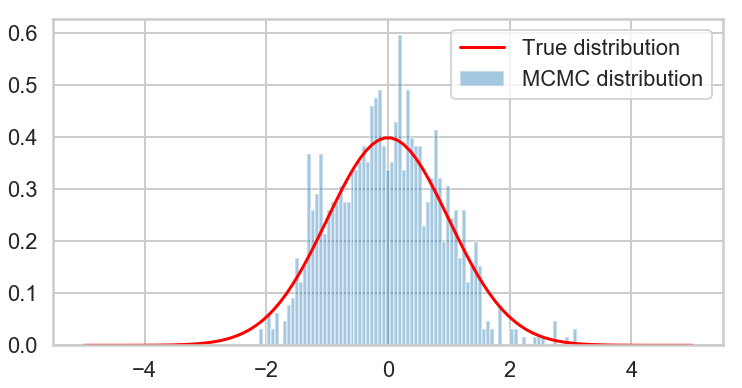

In [51]:
samps = metropolis2(norm.pdf, uniprop, 1000, 0.0)
plt.hist(samps,bins=80, alpha=0.4, label=u'MCMC distribution', normed=True); 
#plot the true function
xxx= np.linspace(-5,5,100)
plt.plot(xxx, norm.pdf(xxx), 'r', label=u'True distribution') 
plt.legend()
print("starting point was ", 0)

In [52]:
x0 = 20

In [53]:
samps = metropolis2(norm.pdf, uniprop, 100000, x0)

/Users/totucuong/miniconda3/envs/sdk/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


starting point was  20


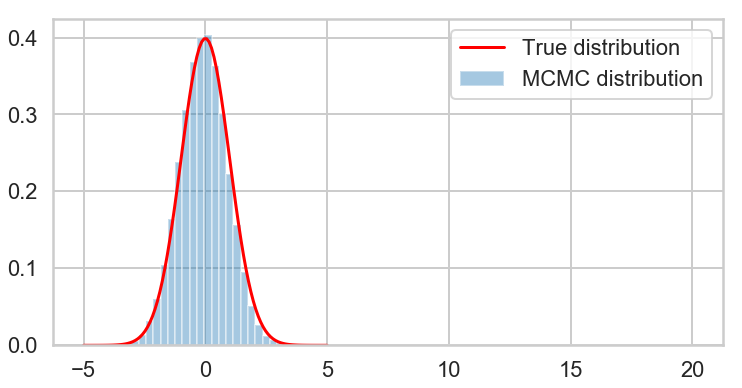

In [54]:
plt.hist(samps,bins=80, alpha=0.4, label=u'MCMC distribution', normed=True); 
#plot the true function
xxx= np.linspace(-5,5,100)
plt.plot(xxx, norm.pdf(xxx), 'r', label=u'True distribution') 
plt.legend()
print("starting point was ", x0)


#### Problem 2: Sampling from a mixture of 2 Normals

In [55]:
# target distribution
p = lambda x: 0.3*np.exp(-0.2*x**2) + 0.7*np.exp(-0.2*(x-10)**2)

In [56]:
# proposal distribution
from scipy.stats import norm
q = lambda xi: norm(xi, 100)

In [58]:
def metropolis_hastings_sample(p, q, x0 = 0, N=5000):
    x = np.zeros(N)
    x[0] = x0
    for i in range(N-1):
        u = np.random.rand()
        proposal = q(x[i]).rvs()
        acceptance = np.min([1, (p(proposal)*q(proposal).pdf(x[i]))/(p(x[i])*q(x[i]).pdf(proposal))])
        if u < acceptance:
            x[i+1] = proposal
        else:
            x[i+1] = x[i]
    return x

In [59]:
samples = metropolis_hastings_sample(p,q)

In [60]:
normalized_factor = quad(p, -10, 20)

/Users/totucuong/miniconda3/envs/sdk/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


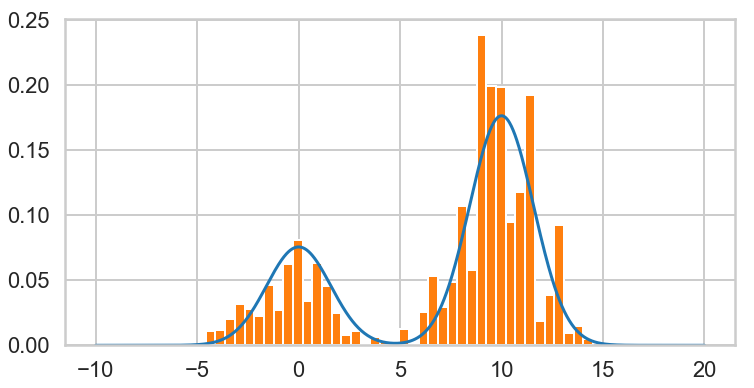

In [61]:
x = np.linspace(-10,20, 1000)
plt.plot(x,p(x)/normalized_factor[0])
plt.hist(samples, bins=40,normed=True);


### Gibbs sampling

Gibss sampling is another MCMC algorithm for obtaining approximate draws from a joint distribution, based on sampling from **conditional** distributions one at a time: at each stage, one variable is updated (keeping all other varibles fixed) by drawing from the condtional distributions of that variable given all other variables. This approach is very useful when we have conditional distributions that are pleasant to work with.

We have to major Gibbs samplers:

1. Systematic scan Gibbs sampler: components (dimensions, variables) are updated one by one in order
2. Random scan Gibbs sampler: a randomly chosen component is update at each stag.

We illustrate Gibbs sampler in the context of bivariate $p(X,Y)$ and both $X, Y$ are discrete.


**Systematic scan Gibbs sampler**: Let X and Y be discrete r.v.s with joint PMF $p_{X,Y}(x,y) = p(X=x, Y=y)$. We wish to construct a two-dimensional Markov chain $(X_n, Y_n)$ whose stationary distribution is $p_{X,Y}$. If the current state is $(X_n, Y_n) = (x_n,y_n)$, then:

1. Draw a value $x_{n+1}$ from the conditional distribution of X given $Y = y_n$ and set $X_{n+1} = x_{n+1}$
2. Draw a value $y_{n+1}$ from the conditional distribution of Y given $X = x_{n+1}$, and set $Y_{n+1} = y_{n+1}$
3. Repeat step 1 and step 2 over and over, the stationary distribution of the chain $(X_0, Y_0),(X_1, Y_1), \dots$ is $p_{X,Y}$

**Random scan Gibbs sampler** The difference compared to systematic scan Gibbs sampler is that in each stage, it picks a unifomrly random component and updates it, according to the conditional distributions given the other component:

1. Choose which component to update, with equal probabilities.
2. If the X-coponent was chosen, draw a value $x_{n+1}$ from the conditional distribution of X given $Y = y_n$ and set $X_{n+1}= x_{n+1}, Y_{n+1} = y_n$. We do similar update if $Y_n$ is choosen to update.
3. Repeat steps 1 and 2 over and over, the stationary distribution of the chain $(X_0, Y_0), (X_1, Y_1), \dots$ is $p_{X,Y}$

**Example**: Building a Gibbs sampler for density $$f(x,y) = x^2exp(-xy^2 - y^2 + 2y -4x)$$

We need to find out the conditional pmf of $X$ and $Y$

Holding y constant, we have $$f(x\mid y) = exp(-y^2 +2y)Gamma(3, y^2 + 4)$$

Holding x constant, we have $$f(y\mid x = \cal{N}(\mu = \frac{1}{1+x}, \sigma^2 = \frac{1}{2(1+x)})$$

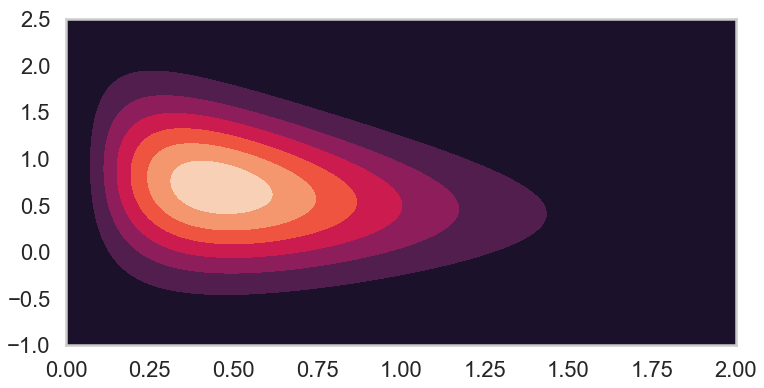

In [39]:
func = lambda x,y: x**2*np.exp( -x*y**2 - y**2 + 2*y - 4*x )

numgridpoints=400
x = np.linspace(0,2,numgridpoints)
y = np.linspace(-1,2.5,numgridpoints)
xx,yy = np.meshgrid(x,y)
zz = np.zeros((numgridpoints,numgridpoints))
for i in np.arange(0,numgridpoints):
    for j in np.arange(0,numgridpoints):
        zz[i,j]=func(xx[i,j],yy[i,j])
        
plt.contourf(xx,yy,zz);

In [40]:
def xcond(y):
    return gamma.rvs(3, scale=1/(y*y + 4))

In [41]:
def ycond(x):
    return norm.rvs(1/(1+x), scale=1.0/np.sqrt(2*(x+1)))

In [42]:
def gibbs(xgiveny_sample, ygivenx_sample, N, start = [0,0]):
    x=start[0]
    y=start[1]
    samples=np.zeros((N+1, 2))
    samples[0,0]=x
    samples[0,1]=y
    
    for i in range(1,N,2):
        x=xgiveny_sample(y)
        samples[i,0]=x
        samples[i, 1]=y
        
        y=ygivenx_sample(x)
        samples[i+1,0]=x
        samples[i+1,1]=y
        
    return samples

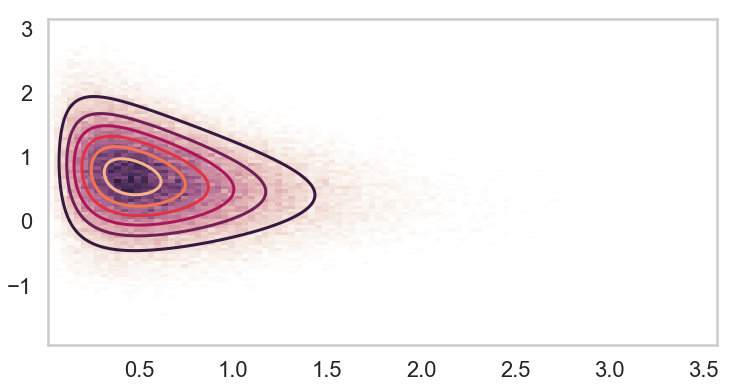

In [43]:
out=gibbs(xcond, ycond, 100000)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
plt.hist2d(out[10000:,0],out[10000:,1], normed=True, bins=100, cmap=cmap)
plt.contour(xx,yy,zz)
plt.show()

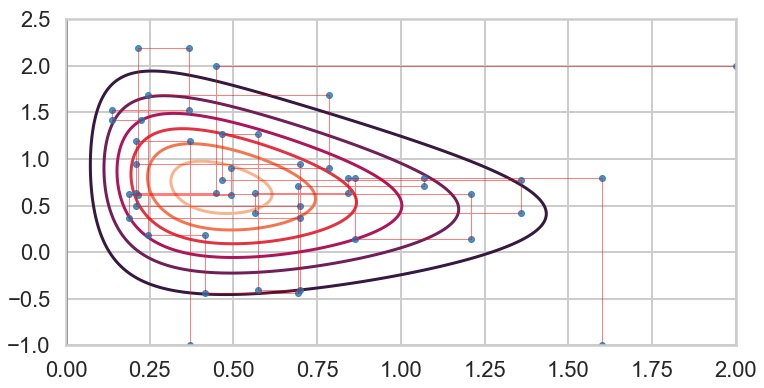

In [44]:
out=gibbs(xcond, ycond, 10000, start = [2,2])
nr_t = 50
plt.contour(xx,yy,zz)
plt.plot(out[:nr_t, 0],out[:nr_t, 1], '.',alpha=0.8)
plt.plot(out[:nr_t, 0],out[:nr_t, 1], c='r', alpha=0.5, lw=1)

In [45]:
def corrplot(trace, maxlags=50, dimension_label=''):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])
    plt.xlabel('lags')
    plt.ylabel('autocorrelation')
    plt.title(dimension_label)


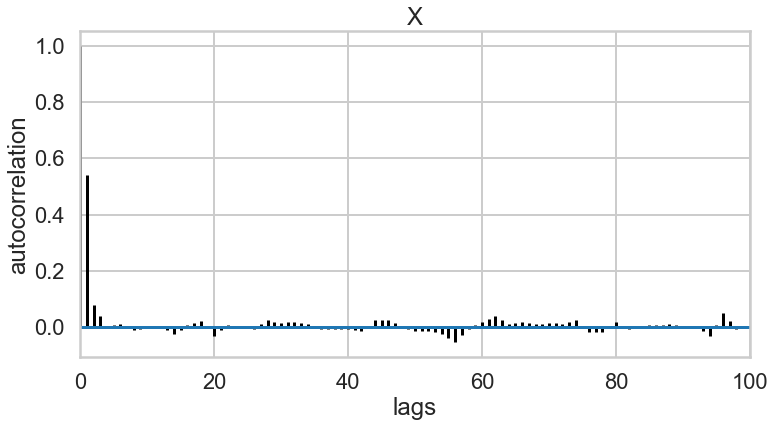

In [46]:
corrplot(out[4000:,0], 100, 'X')

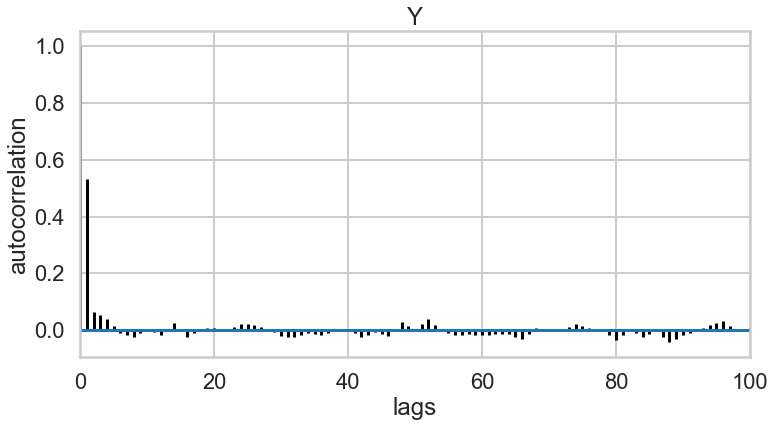

In [47]:
corrplot(out[4000:,1], 100, 'Y')


# Appendix

## Markov Chain Theory


- Markov Chain is a model that describe a sequence of random variable $X_0, X_1, \ldots, X_n, \ldots$. They are all drawn from a distribution, where the value of $X_n$ depends only on the immediate variable $X_{n-1}$. In other words, it lies happily between **complete independence assumption** and **complete  dependence assumption**.




Markov chain lives in both in space and time. Space here means the domain of $X_t$, and time here means the domain of $t$. Both space and time can be discrete or continuous. We will first focus only on discrete domains. Moreover our discrete space will be finite also. That is $dom(X_t) = \{1,2,\ldots, M\}$

We now define formally Markov chains:

   A sequence of random variables $X_0, X_1, \ldots, X_n, \ldots$ taking values in the state space $\{1,2,\ldots, M\}$ is called a **Markov chain** if for all $n \geq 0$, $$p(X_{n+1} = j \mid X_n = i, X_{n-1} = i_{n-1}, \ldots, X_0 = i_0) = p(X_{n+1} = j \mid X_{n} = i)$$
   
The quantity $p(X_{n+1} = j \mid X_{n} = i)$ is called the transition probability from state i to state j.

**Time-homogenenous** Markov chain has the transition probability $p(X_{n+1} = j \mid X_{n} = i)$ unchanged in time.

**Markov property** is the condition in the defnition. It says that we need only $X_n$ to predict $X_{n+1}$. If n is the presents, before n is the past, after n is the future, Markov property says that given the present the past and the future are conditionally independent.

Knowing the dynamics of a Markov chain means knowing its transition probability from one state to another state. These dynamics is encoded in a matrix, called the transiation matrix, whose (i,j) entry is the probability going from state i to state j in one step of the chain: M-by-M matrix $Q = (q_{ij})$

An example of Markov chain: 

![example](../gfx/mchain.png)

**n-step transition probability** from i to j is the probability of being at j exactly n steps after **staring** at i. We denote this by $q_{ij}^{(n)} = p(X_n = j \mid X_0 = i)$.

Note that $q_{ij}^{(2)} = \sum_{k}q_{ik}q_{kj}$

The right hand side is the (ij) entry of $Q^2$. We can say that $Q^2$ is the two-step transition probabilities. By induction, the nth power. In other words, the ith row of $Q^n$ is the conditional PMF of $X_n$ given $X_0 = i$

**mariginal distributions** $p(X_1), \ldots, p(X_n), \ldots$. To compute these distributions, we need $Q$ and the intial distribution of $X_0$. Suppose the marginal distribution $p(X_0) = (t_1, \dots, t_M)$, then the marginal distribution at any time can be computed from the transition matrix, averaging over all the state using LOTP. 

Define $\v{t} = (t_1, \dots, t_M)$ by $t_i = p(X_0 = i)$. Then the marginal distribution of $X_n$ is given by the vector $\v{t}Q^n$, viewing $\v{t}$ as row vector.

We now study a number of characteristics of a Markov chain. They are important in understanding the long-run behaviour of the Markov chain. 

**recurrent** versus **transient**

    State i of a Markov chain is recurrent if starting from i, the probability is 1 that the chain will eventually return to i. Otherwise, the state is transient, which means that if the chain starts from i, there is a positive probability of never returning to i.

Recall that the number of failures, in repeated Bernoulli trials, before the first successful trial follow the Geometric distribution with parameter p: $X \sim Geom(p),$ where $p(X = k) = q^kp$. Note that in ``scipy.stats.geom`` have a slightly different definition, where k counts also the success trial.
![recurrent_transient](gfx/recurrent.jpg)

In [1]:
%matplotlib inline
from scipy.stats import geom
import numpy as np
import matplotlib.pyplot as plt

def mygeom(k, p):
    return (1-p)**k*p

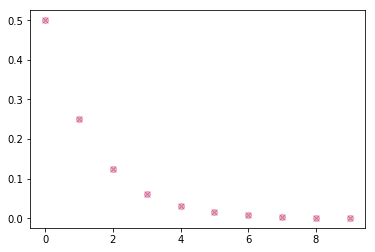

In [2]:
k = np.arange(10) 
plt.plot(k, mygeom(k,1/2), 'o', color='r', alpha=0.3)
plt.plot(k, geom.pmf(k+1, 1/2), 'x', color='b', alpha=0.3)

There is a connection between transient states and geometric distribution: **the number of returns to transient state is Geometric**. Let i be a transient state of a Markov chain. Suppose the probability of never returning to i, starting from i, is a positive number $p >0$. Then, starting from i, the number of times that the chain returns to i before leaving forever is distributed Geom(p)

This means, the chain will eventually leave state i forever. I understand this as probability of the number of times the chain returns before leaving forever approaches 0 as this number increase (See the graph). Hence eventually, the chain leave i forever.

How do we know if a state is recurrent? We cannot analyze the graph of Markov chain visually if there are too many states. **Irreducibility** allows us to do that: if it is possible to get from any state to any other state.

**Irreducible and reducible chain**. 
        
A Markov chain with transition matrix $Q$ is irreducible if for any two states i and j, it is possible to go from i to j in a finite number of steps (with positive probability). That is, for any states i, j there is some positive integer n such that the (i,j) entry of $Q^n$ is positive. A Markov chain that is not irreducible is called reducible.
  
It is easy to prove irreducibility implies all states are reccurrent.

We have irreducbile implies all recurrent. But the converse is not true. We can have a reducible Markov chain whose states are all recurrent. For example:

![recurrent reducible](../gfx/reducible_recurrent.jpg)

**period of a state, periodic and aperiodic chain**

The period of a state i in a Markov chain is the greated common divisor (gcd) of a the possible numbers of steps it can take to return to i when starting at i. In other words, the period of i is the gcd of numbers n such that the (i,i) entry of $Q^n$ is positive.

A state is called **aperiodic** if its period equals 1, and period otherwise. The chain itself is called aperiodic if all its states are aperiodic, and periodic otherwise


![aperiodic](../gfx/aperiodic.jpg)

### Stationary distribution

We are interested in the behavior of Markov chain in long run. At first, the chain may spend tim in transient states. Eventually though, the chain will spend all its time in recurrent states. But what fraction of time will it spend in each of the recurrent states? This is answered by the **stationary distribution** of the chain, also known as the **steady-state** distribution.

We will show that for irreducible and aperiodic Markov chains, the stationary distribution describles the long-run behavior of the chain, regardless of its intial conditions.

**Stationary distribution**. A row vector $\v{s} = (s_1, \ldots, s_M)$ such that $s_i \geq 0$ and $\sum_is_i = 1$ is a stationary distribution for a Markov chain with transition matrix Q if $$\sum_is_iq_{ij} = s_j$$ for all j, ore equivalently, $$\v{s}Q = \v{s}$$

From the definition, we can see that if the distribution of intial state $X_0$ is $\v{s}$, then the distribution of $X_1$, $X_2$, etc., all will have distribution $\v{s}$. In other words, if a Markov chain starts with its stationary distribution, it will stay in it forever.

**Existence and uniqueness**

For finite state space, a stationary distribution always exists (This is due to Perron-Frobenious theorem)

Any irreducible Markov chain has an unique stationary distribution. In this distribution, every state has positive probability. 

**Convergence**

We have the following important theorem without proof.

**Convergence to stationary distribution**.  Let $X_0, X_1, \ldots$ be a Markov chain with stationary distribution $\v{s}$ and transition matrix $Q$, such that some power $Q^m$ is positive in all entries. (These assumptions are equivalent to assuming that the chain is irreducible and aperiodic.) Then $P(X_n = i) \rightarrow s_i$ as $n \rightarrow \infty$. In terms of the transition matrix, $Q^n$ converges to a matrix in which each row is s.
Therefore, after a large number of steps, the probability that the chain is in state i is close to the stationary probability si, regardless of the chain's initial conditions. Intuitively, the extra condition of aperiodicity is needed in order to rule out chains that just go around in circles, such as the chain in the following example.

In [26]:
from numpy.linalg import matrix_power
Q = np.array([[0,1,0,0,0], [0, 0, 1, 0, 0], [0,0,0,1,0], [0,0,0,0,1], [1,0,0,0,0]])
intial = np.array([1,0,0,0,0])
Q

array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0]])

In [27]:
for n in range(10,20):
    print('n = ', n) 
    print(np.dot(intial.T, matrix_power(Q,n)))
    print('-'*30)

n =  10
[1 0 0 0 0]
------------------------------
n =  11
[0 1 0 0 0]
------------------------------
n =  12
[0 0 1 0 0]
------------------------------
n =  13
[0 0 0 1 0]
------------------------------
n =  14
[0 0 0 0 1]
------------------------------
n =  15
[1 0 0 0 0]
------------------------------
n =  16
[0 1 0 0 0]
------------------------------
n =  17
[0 0 1 0 0]
------------------------------
n =  18
[0 0 0 1 0]
------------------------------
n =  19
[0 0 0 0 1]
------------------------------


In [28]:
# transition
import numpy as np
transition_matrix = np.array([[1/3, 2/3], [0.5, 0.5]])
transition_matrix

array([[0.33333333, 0.66666667],
       [0.5       , 0.5       ]])

In [29]:
# now for higher n. We should see that it converges to the
# stationary distribution
tm_before = transition_matrix
for i in range(5):
    tm_next = np.dot(tm_before, transition_matrix)
    print(tm_next)
    print("-----------------")
    tm_before = tm_next

[[0.44444444 0.55555556]
 [0.41666667 0.58333333]]
-----------------
[[0.42592593 0.57407407]
 [0.43055556 0.56944444]]
-----------------
[[0.42901235 0.57098765]
 [0.42824074 0.57175926]]
-----------------
[[0.42849794 0.57150206]
 [0.42862654 0.57137346]]
-----------------
[[0.42858368 0.57141632]
 [0.42856224 0.57143776]]
-----------------


We can compute the stationary distribution analytically. Assume that it is  $s = [p,1-p]$. Then $$sT = s$$ give us $$p(1/3) + (1-p)(1/2) = p$$

and thus $p = 3/7$

And we can see that we can get to this stationary distribution starting from multiple places

**reversibility**

Stationary distribution is important to understand a Markov chain's long-run behavior. 

To find stationary distribution, we need to find eigenvectors of the transition matrix. This involving solving a high-degree polynomial which can be difficult when the number of states (hence the size of Q) is high.

Fortunately, there is an important special cases where working with eginevalue equations for large matrices can be avoided.

**Reversibiliy**. Let $Q = (q_{ij})$ be the transition matrix of a Markov chain. Suppose there is $\v{s} = (s_1, \dots, s_M)$ with $s_i \geq 0$, $\sum_i s_i = 1$, such that $$s_iq_{ij} = s_{j}q_{ji}$$

for all states i and j.

This equation is called the **reversibility** or **detailed balance** condition, and we say that the chain is **reversible** with respect to $\v{s}$ if it holds.

**Reversibiliy**. Let $Q = (q_{ij})$ be the transition matrix of a Markov chain. Suppose there is $\v{s} = (s_1, \dots, s_M)$ with $s_i \geq 0$, $\sum_i s_i = 1$, such that $$s_iq_{ij} = s_{j}q_{ji}$$

for all states i and j.

This equation is called the **reversibility** or **detailed balance** condition, and we say that the chain is **reversible** with respect to $\v{s}$ if it holds.

In continous state spaces, the transition matrix T becomes an integral kernel K. We will discuss more details when presenting MCMC methods.


### Metropolis-Hastings

**The Metropolis-Hasting algorithm is a general recipe that lets us start with any irreducible Markov chain on the state space of interest and then modify it into a new Markov chain that has desired stationary distribution**

Our goal is to modify a MC P to construct a MC $X_0, X_1, \dots$ with stationary distribution $s$. The pseudocode is as follows.

1. Start at any state $X_0$ (choosen randomly or deterministically)
2. If $X_n = i$, propose a new state j using the transition probabilities in the ith row of the original transition matrix P.
3. Compute the acceptance probability $a_{ij} = min(\frac{s_jp_{ij}}{s_ip_{ij}},1)$
4. Flip a coin that lands Heads with probability $a_{ij}$
5. If the coin lands Heads, accept the proposal (i.e., go to j) setting $X_{n+1} = j$. Otherwise, reject the proposal (i.e., stay at i), setting $X_{n+1} = i$.


**Bayesian inference** The Metropolis-Hastings algorithm can slo be applied in a continous state space, using pdfs instead of pmfs. This is very useufl in Bayesian inference, where we oftwent want to study **the posterior distribution** of an unknown parameter. This posterior distribution maybe very complicated to work with analytically, and may have an unknown normalizing constant. 


We have the pseudocode for Metropolis-Hasting algorithm as follows.

1. Initialize $x^{(0)}$
2. For i = 0 to N-1
    - Sample $u \sim U_{[0,1]}$
    - Sample $x^* \sim q(x^* | x^{(i)})$
    - If $u < A(x^{(i)} , x^*) = min(1, \frac{p(x^*)q(x^i|x^{*})}{p(x^i)q(x^*|x^{(i)})})$
        - $x^{(i+1)} = x^*$
    - Else
        - $x^{(i+1)} = x^{(i)}$
       

### Markov chain in continous state space



In [40]:
# target distribution
p = lambda x: 0.3*np.exp(-0.2*x**2) + 0.7*np.exp(-0.2*(x-10)**2)

In [41]:
# proposal distribution
from scipy.stats import norm
q = lambda xi: norm(xi, 100)

In [43]:
def metropolis_hastings_sample(p, q, x0 = 0, N=5000):
    x = np.zeros(N)
    x[0] = x0
    for i in range(N-1):
        u = np.random.rand()
        proposal = q(x[i]).rvs()
        acceptance = np.min([1, (p(proposal)*q(proposal).pdf(x[i]))/(p(x[i])*q(x[i]).pdf(proposal))])
        if u < acceptance:
            x[i+1] = proposal
        else:
            x[i+1] = x[i]
    return x

In [44]:
samples = metropolis_hastings_sample(p,q)

In [47]:
normalized_factor = quad(p, -10, 20)

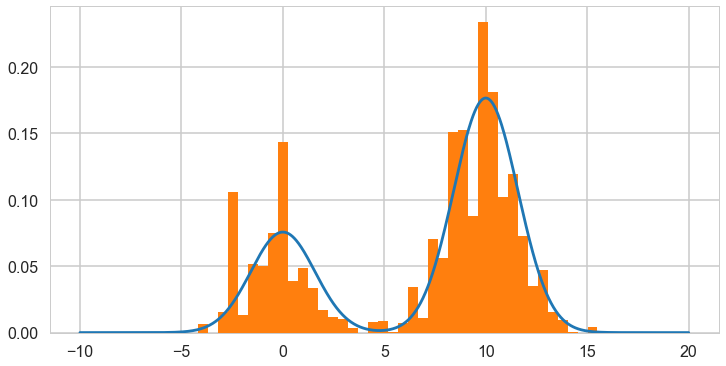

In [48]:
x = np.linspace(-10,20, 1000)
plt.plot(x,p(x)/normalized_factor[0])
plt.hist(samples, bins=40,normed=True);

**Example**: Normal-Normal conjugacy

Let $Y \mid \theta \sim \cal{N}(\theta, \sigma^2)$, where $\sigma^2$ is known but $\theta$ is unknown.

Using Bayesian framework, we treat $\theta$ as a random variable, with prior given by $\theta \sim \cal{N}(\mu, \tau^2)$ for some known constants $\mu$ and $\sigma^2$. That is, we have a two level model 
$$\theta \sim \cal{N}(\mu, \tau^2)\\ Y \mid \theta \sim \cal{N}(\theta, \sigma^2)$$

We will use the Metropolis-Hastings algorithm to find the posterior mean and variance of $\theta$ after observing the value of $Y$.

After observing Y = y, we have $f_{\theta \mid y}(\theta \mid y) \propto f_{y\mid \theta}(y \mid \theta)f_{\theta}(\theta) \propto e^{-\frac{1}{2\sigma^2}(y-\theta)^2}e^{-\frac{1}{2\tau^2}(\theta-\mu)^2}$. 

By completing square, we can obtain an explitie formula for the posterior distribution of $\theta$:

![normal normal](../gfx/normal_normal.jpg)

Suppose that we didn't know how to complete the square (we do not have the above formula). Or we just simply want to verify our formula for a specific values of $y, \sigma^2, \mu, \tau^2$. We can do this by simulating from the posteior distribution of $\theta$, using the Metropolis-Hastings algorithm to construct a Markov chain whose stationary distribution is $f_{\theta \mid y}(\theta \mid y)$.

A Metropolis-Hastings algorithm for generating $\theta_0, \theta_1, \ldots$ is as follows.

### Gibbs Sampling

Gibss sampling is an MCMC algorithm for obtaining approximate draws from a joint distribution, based on sampling from **conditional** distributions one at a time: at each stage, one variable is updated (keeping all other varibles fixed) by drawing from the condtional distributions of that variable given all other variables.

This approach is very useful when we have conditional distributions that are pleasant to work with.

We have to major Gibbs samplers:

1. Systematic scan Gibbs sampler: components (dimensions, variables) are updated one by one in order
2. Random scan Gibbs sampler: a randomly chosen component is update at each stag.

We illustrate Gibbs sampler in the context of bivariate $p(X,Y)$ and both $X, Y$ are discrete.

**Systematic scan Gibbs sampler**: Let X and Y be discrete r.v.s with joint PMF $p_{X,Y}(x,y) = p(X=x, Y=y)$. We wish to construct a two-dimensional Markov chain $(X_n, Y_n)$ whose stationary distribution is $p_{X,Y}$. If the current state is $(X_n, Y_n) = (x_n,y_n)$, then:

1. Draw a value $x_{n+1}$ from the conditional distribution of X given $Y = y_n$ and set $X_{n+1} = x_{n+1}$
2. Draw a value $y_{n+1}$ from the conditional distribution of Y given $X = x_{n+1}$, and set $Y_{n+1} = y_{n+1}$
3. Repeat step 1 and step 2 over and over, the stationary distribution of the chain $(X_0, Y_0),(X_1, Y_1), \dots$ is $p_{X,Y}$

**Random scan Gibbs sampler** The difference compared to systematic scan Gibbs sampler is that in each stage, it picks a unifomrly random component and updates it, according to the conditional distributions given the other component:

1. Choose which component to update, with equal probabilities.
2. If the X-coponent was chosen, draw a value $x_{n+1}$ from the conditional distribution of X given $Y = y_n$ and set $X_{n+1}= x_{n+1}, Y_{n+1} = y_n$. We do similar update if $Y_n$ is choosen to update.
3. Repeat steps 1 and 2 over and over, the stationary distribution of the chain $(X_0, Y_0), (X_1, Y_1), \dots$ is $p_{X,Y}$

**Example**: Building a Gibbs sampler for density $$f(x,y) = x^2exp(-xy^2 - y^2 + 2y -4x)$$

We need to find out the conditional pmf of $X$ and $Y$

Holding y constant, we have $$f(x\mid y) = exp(-y^2 +2y)Gamma(3, y^2 + 4)$$

Holding x constant, we have $$f(y\mid x = \cal{N}(\mu = \frac{1}{1+x}, \sigma^2 = \frac{1}{2(1+x)})$$

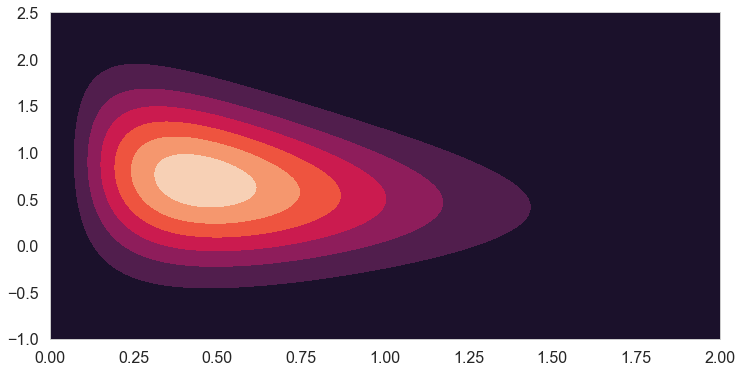

In [50]:
func = lambda x,y: x**2*np.exp( -x*y**2 - y**2 + 2*y - 4*x )

numgridpoints=400
x = np.linspace(0,2,numgridpoints)
y = np.linspace(-1,2.5,numgridpoints)
xx,yy = np.meshgrid(x,y)
zz = np.zeros((numgridpoints,numgridpoints))
for i in np.arange(0,numgridpoints):
    for j in np.arange(0,numgridpoints):
        zz[i,j]=func(xx[i,j],yy[i,j])
        
plt.contourf(xx,yy,zz);

In [51]:
def xcond(y):
    return gamma.rvs(3, scale=1/(y*y + 4))

def ycond(x):
    return norm.rvs(1/(1+x), scale=1.0/np.sqrt(2*(x+1)))

def gibbs(xgiveny_sample, ygivenx_sample, N, start = [0,0]):
    x=start[0]
    y=start[1]
    samples=np.zeros((N+1, 2))
    samples[0,0]=x
    samples[0,1]=y
    
    for i in range(1,N,2):
        x=xgiveny_sample(y)
        samples[i,0]=x
        samples[i, 1]=y
        
        y=ygivenx_sample(x)
        samples[i+1,0]=x
        samples[i+1,1]=y
        
    return samples

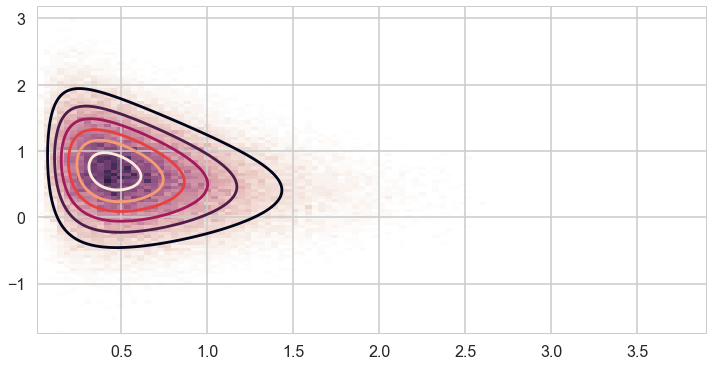

In [52]:
out=gibbs(xcond, ycond, 100000)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
plt.hist2d(out[10000:,0],out[10000:,1], normed=True, bins=100, cmap=cmap)
plt.contour(xx,yy,zz)
plt.show()

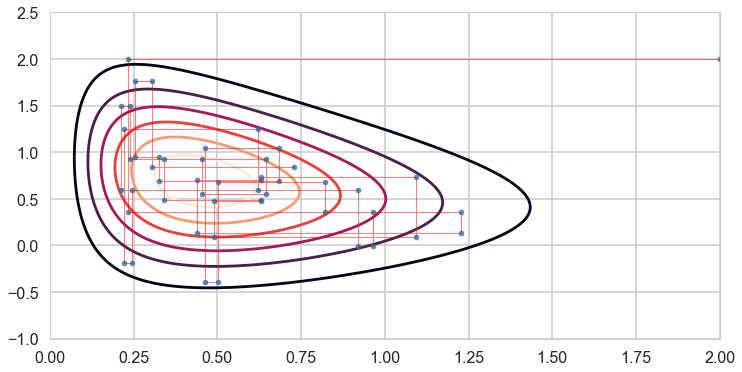

In [53]:
out=gibbs(xcond, ycond, 10000, start = [2,2])
nr_t = 50
plt.contour(xx,yy,zz)
plt.plot(out[:nr_t, 0],out[:nr_t, 1], '.',alpha=0.8)
plt.plot(out[:nr_t, 0],out[:nr_t, 1], c='r', alpha=0.5, lw=1)

In [54]:
def corrplot(trace, maxlags=50, dimension_label=''):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])
    plt.xlabel('lags')
    plt.ylabel('autocorrelation')
    plt.title(dimension_label)


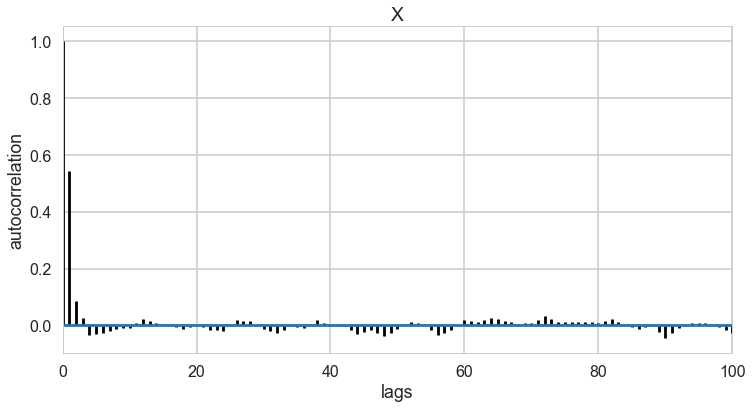

In [55]:
corrplot(out[4000:,0], 100, 'X')

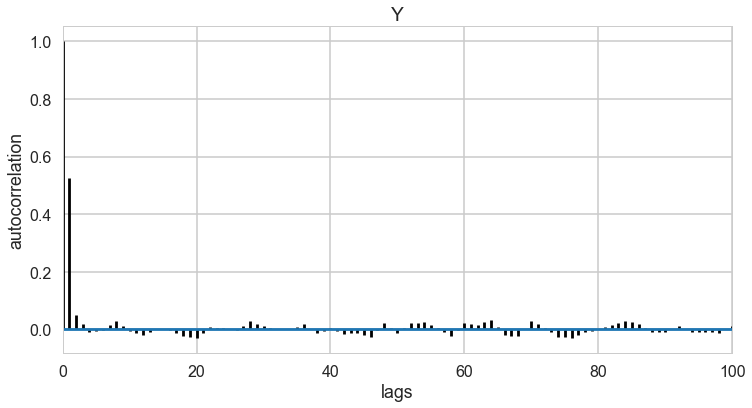

In [56]:
corrplot(out[4000:,1], 100, 'Y')
